In [2]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

data75768


In [3]:
# 查看工作区文件，该目录下除data目录外的变更将会持久保存。请及时清理不必要的文件，避免加载过慢。
# View personal work directory. 
# All changes, except /data, under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio

8574617.ipynb  data  finetuning  visualdl_log  work


In [4]:
#解压数据集
# !unzip -d work data/data75768/food-11.zip 
# !rm -rf work/__MACOSX

In [5]:
#一、导入相关库
import os
import paddle
import paddle.vision.transforms as T
import numpy as np
from PIL import Image
import paddle
import paddle.nn.functional as F
import cv2
from sklearn.utils import shuffle

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

In [6]:
#二、读取数据
import io
import os
from PIL import Image

data_path = 'work/food-11/'  # 设置初始文件地址
character_folders = os.listdir(data_path)  # 查看地址下文件夹
print('character_folders:{}'.format(character_folders))

# 每次运行前删除txt，重新新建标签列表
if(os.path.exists('work/food-11/training.txt')):  # 判断有无文件
    os.remove('work/food-11/training.txt')  # 删除文件
if(os.path.exists('work/food-11/validation.txt')):
    os.remove('work/food-11/validation.txt')
if(os.path.exists('work/food-11/testing.txt')):
    os.remove('work/food-11/testing.txt')

character_folders:['training', 'testing.txt', 'validation.txt', 'training.txt', 'testing', 'validation']


In [7]:
# 三、数据预处理
# 数据集共有三个资料夹，分别为training、validation 以及 testing。这三个文件夹里直接存放着照片，照片名称格式为 [类别]_[编号].jpg，例如 3_100.jpg 即为类别 3 的照片（编号不重要），每个文件夹里都有11类。
# 对这些样本进行一个标注处理，最终生成train.txt/valid.txt/test.txt三个数据标注文件。

# 数据集根目录
DATA_ROOT = 'work/food-11'

# 训练集与验证集标注生成函数
def generate_annotation(mode):
    # 建立标注文件
    with open('{}/{}.txt'.format(DATA_ROOT, mode), 'w') as f:
        # 对应每个用途的数据文件夹，train/valid/test
        train_dir = '{}/{}'.format(DATA_ROOT, mode)

        # 图像样本所在的路径
        image_path = '{}'.format(train_dir) 

        # 遍历所有图像
        for image in os.listdir(image_path):
            # 图像完整路径和名称
            image_file = '{}/{}'.format(image_path, image)
            for k in image:
                if k=='_':   # 如果图片名称有下划线‘—’
                    stop = image.index(k)   # 下划线所在索引
                    label_index = image[0:stop] # image的索引从0——下划线前的数字为为图片的标签
                    label_index =int(label_index)

            try:
                # 验证图片格式是否ok
                with open(image_file, 'rb') as f_img:
                    image = Image.open(io.BytesIO(f_img.read()))
                    image.load()      
                    if image.mode == 'RGB':
                        f.write('{}\t{}\n'.format(image_file, label_index))
            except:
                continue


generate_annotation('training')  # 生成训练集标注文件
generate_annotation('validation')  # 生成验证集标注文件

In [8]:
# 测试数据集的特别处理
# 这里需要说明的是由于测试集没有标签，就不能直接进行实例化，即不能直接使用FoodDataset函数。
# 因此在标注的时候将其补图片路径补为0，才能输入网络进行预测。这对结果是没有影响的，实例化只是对测试集的图片进行处理。(由于测试数据集没有标签，所以只生成其数据集的路径文件)

# 数据集根目录
DATA_ROOT = 'work/food-11'
def generate_annotation(mode):

    with open('{}/{}.txt'.format(DATA_ROOT, mode), 'w') as f:
        # 对应每个用途的数据文件夹，train/valid/test
        train_dir = '{}/{}'.format(DATA_ROOT, mode)

        # 图像样本所在的路径
        image_path = '{}'.format(train_dir) 

        # 遍历所有图像
        for image in os.listdir(image_path):
            # 图像完整路径和名称
            image_file = '{}/{}'.format(image_path, image)
            label_index = 0   #测试集没有标签，为了后续的预测，讲其标签设置为0

            try:
                # 验证图片格式是否ok
                with open(image_file, 'rb') as f_img:
                    image = Image.open(io.BytesIO(f_img.read()))
                    image.load()

                    if image.mode == 'RGB':
                        f.write('{}\t{}\n'.format(image_file,label_index))
            except:
                continue
# 生成测试集               
generate_annotation('testing')

In [9]:
#四、 数据集封装处理
# 继承自PaddlePaddle的Dataset类。

import paddle
import paddle.vision.transforms as T
import numpy as np
from PIL import Image

__all__ = ['FoodDataset']

# 定义图像的大小
image_shape = [3,100,100]
IMAGE_SIZE = (image_shape[1], image_shape[2]) # [100,100]

In [10]:
class FoodDataset(paddle.io.Dataset):
    # 数据集类的定义
    def __init__(self, mode='training'):
        # 初始化函数
        assert mode in ['training','validation', 'testing'], 'mode is one of train, valid, test.'
        self.data = []
        with open('work/food-11/{}.txt'.format(mode)) as f:
            for line in f. readlines():
                info = line.strip().split('\t')
                if len(info) > 1:
                    self.data.append([info[0].strip(), info[1].strip()])
        if mode == 'training':
            self.transforms = T.Compose([
                T.Resize((256,256)),
                T.RandomCrop(IMAGE_SIZE),
                #随机裁剪大小[100,100]
                T.RandomRotation(15),
                T.RandomHorizontalFlip(0.5),#随机水平翻转
                T.RandomVerticalFlip(0.5),
                #随机垂直翻转
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.2224,0.225])#图像归一化
            ])
        else:
            self.transforms = T.Compose([
                T.Resize((256,256)), # 图像大小修改
                T.RandomCrop(IMAGE_SIZE), # 随机裁剪
                T.ToTensor(), # 数据的格式转换和标准化HWC=>CHW
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.2224, 0.225])#图像归一化
            ])
        
    def __getitem__(self, index):
        # 根据索引获取单个样本

        image_file, label = self.data[index]
        image = Image.open(image_file)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        image = self.transforms(image)
        return image, np.array(label, dtype='int64')
    
    def __len__(self):
    # 获取样本总数
        return len(self.data)


In [11]:
# 实例化数据集类
# 根据所使用的数据集需求实例化数据集类，并查看总样本量。
training_dataset = FoodDataset(mode='training')
validation_dataset = FoodDataset(mode='validation')

print('训练数据集：{}张; 验证数据集：{}张'.format(len(training_dataset),len(validation_dataset)))

训练数据集：9866张; 验证数据集：3430张


In [12]:
# 实例化测试集类
# 根据所使用的数据集需求实例化测试集类，并查看测试总样本量。
testing_dataset = FoodDataset(mode='testing')
print('测试数据集样本量：{}张'.format(len(testing_dataset)))

测试数据集样本量：3347张


In [13]:
#五、搭建模型
# 继承paddle.nn.Layer类，用于搭建模型

#构建模型
class Residual(paddle.nn.Layer):
    def __init__(self, in_channel, out_channel, use_conv1x1=False, stride=1):
        super(Residual, self).__init__()
        self.conv1 = paddle.nn.Conv2D(in_channel, out_channel, kernel_size=3, padding=1, stride=stride)
        self.conv2 = paddle.nn.Conv2D(out_channel, out_channel, kernel_size=3, padding=1)
        if use_conv1x1: #使用1x1卷积核
            self.conv3 = paddle.nn.Conv2D(in_channel, out_channel, kernel_size=1, stride=stride)
        else:
            self.conv3 = None
        self.batchNorm1 = paddle.nn.BatchNorm2D(out_channel)
        self.batchNorm2 = paddle.nn.BatchNorm2D(out_channel)

    def forward(self, x):
        y = F.relu(self.batchNorm1(self.conv1(x)))
        y = self.batchNorm2(self.conv2(y))
        if self.conv3:
            x = self.conv3(x)
        out = F.relu(y+x) #核心代码
        return out

In [14]:
def ResNetBlock(in_channel, out_channel, nuim_layers, is_first=False):
    if is_first:
        assert in_channel == out_channel
    block_list = []
    for i in range(nuim_layers):
        if i == 0 and not is_first:
            block_list.append(Residual(in_channel, out_channel,use_conv1x1=True, stride=2))
        else:
            block_list.append(Residual(out_channel, out_channel))
    resNetBlock = paddle.nn.Sequential(*block_list) #用*可以把list列表展开为元素
    return resNetBlock


In [15]:
class ResNetModel(paddle.nn.Layer):
    def __init__(self):
        super(ResNetModel, self).__init__()
        self.b1 = paddle.nn.Sequential(
                    paddle.nn.Conv2D(3,64,kernel_size=7, stride=2, padding=3),
                    paddle.nn.BatchNorm2D(64),
                    paddle.nn.ReLU(),
                    paddle.nn.MaxPool2D(kernel_size=3, stride=2, padding=1))
        self.b2 = ResNetBlock(64, 64, 2, is_first=True)
        self.b3 = ResNetBlock(64, 128, 2)
        self.b4 = ResNetBlock(128, 256, 2)
        self.b5 = ResNetBlock(256, 512, 2)
        self.AvgPool = paddle.nn.AvgPool2D(2)
        self.flatten = paddle.nn.Flatten()
        self.Linear = paddle.nn.Linear(2048, 11)
    def forward(self, x):
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = self.b4(x)
        x = self.b5(x)
        x = self.AvgPool(x)
        x = self.flatten(x)
        x = self.Linear(x)
        return x


In [16]:
# 声明模型
network = ResNetModel()
# 可视化模型
paddle.summary(network,(-1,3,100,100))

W1123 21:49:14.514205   812 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 12.0, Runtime API Version: 11.2
W1123 21:49:14.517634   812 gpu_resources.cc:91] device: 0, cuDNN Version: 8.2.


---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Conv2D-1      [[1, 3, 100, 100]]    [1, 64, 50, 50]         9,472     
 BatchNorm2D-1   [[1, 64, 50, 50]]     [1, 64, 50, 50]          256      
    ReLU-1       [[1, 64, 50, 50]]     [1, 64, 50, 50]           0       
  MaxPool2D-1    [[1, 64, 50, 50]]     [1, 64, 25, 25]           0       
   Conv2D-2      [[1, 64, 25, 25]]     [1, 64, 25, 25]        36,928     
 BatchNorm2D-2   [[1, 64, 25, 25]]     [1, 64, 25, 25]          256      
   Conv2D-3      [[1, 64, 25, 25]]     [1, 64, 25, 25]        36,928     
 BatchNorm2D-3   [[1, 64, 25, 25]]     [1, 64, 25, 25]          256      
  Residual-1     [[1, 64, 25, 25]]     [1, 64, 25, 25]           0       
   Conv2D-4      [[1, 64, 25, 25]]     [1, 64, 25, 25]        36,928     
 BatchNorm2D-4   [[1, 64, 25, 25]]     [1, 64, 25, 25]          256      
   Conv2D-5      [[1, 64, 25, 25]]  

{'total_params': 11209867, 'trainable_params': 11202059}

In [17]:
#六、训练模型
# 实例化模型
inputs = paddle.static.InputSpec(shape=[None, 3, 100, 100], name='inputs')
labels = paddle.static.InputSpec(shape=[None, 11], name='labels')
model = paddle.Model(network,inputs,labels)

# 模型训练相关配置，准备损失计算方法，优化器和精度计算方法
# 定义优化器
# scheduler = paddle.optimizer.lr.LinearWarmup(learning_rate=0.001, warmup_steps=100, start_lr=0, end_lr=0.0005, verbose=True)

# scheduler = paddle.optimizer.lr.LinearWarmup(
#     learning_rate=0.001,  # 调整最终学习率更高些
#     warmup_steps=200,  # 增加预热步数
#     start_lr=0.0,
#     end_lr=0.001,  # 提高预热结束时的学习率
#     verbose=True
# )

# 余弦退火
scheduler = paddle.optimizer.lr.CosineAnnealingDecay(
    learning_rate=0.001,  # 初始学习率
    T_max=10,  # 学习率周期（即每隔 10 轮重置一次）
    eta_min=0.0001  # 最小学习率
)

# optim = paddle.optimizer.RMSProp(learning_rate=scheduler, parameters=model.parameters())
# AdamW 优化器
optim = paddle.optimizer.AdamW(learning_rate=scheduler, parameters=model.parameters(), weight_decay=0.01)

# 或 Momentum-SGD 优化器
# optim = paddle.optimizer.Momentum(learning_rate=scheduler, parameters=model.parameters(), momentum=0.9)

# 配置模型
model.prepare(
    optim,
    paddle.nn.CrossEntropyLoss(),
    paddle.metric.Accuracy()
    )

visualdl = paddle.callbacks.VisualDL(log_dir='visualdl_log')

# 模型训练与评估
model.fit(
        training_dataset,  # 训练数据集
        validation_dataset,   # 评估数据集
        #epochs=10,       # 训练的总轮次
        epochs=10,       # 训练的总轮次
        batch_size=128,  # 训练使用的批大小
        verbose=1,      # 日志展示形式
        callbacks=[visualdl])  # 设置可视化

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/10


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:712: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance."


step 78/78 [==============================] - loss: 2.5785 - acc: 0.1850 - 973ms/step         
Eval begin...
step 27/27 [==============================] - loss: 2.3193 - acc: 0.2143 - 957ms/step        
Eval samples: 3430
Epoch 2/10


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:712: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance."


step 78/78 [==============================] - loss: 2.3129 - acc: 0.2388 - 859ms/step        
Eval begin...
step 27/27 [==============================] - loss: 2.2154 - acc: 0.2583 - 955ms/step        
Eval samples: 3430
Epoch 3/10


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:712: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance."


step 78/78 [==============================] - loss: 1.8236 - acc: 0.2709 - 853ms/step        
Eval begin...
step 27/27 [==============================] - loss: 1.9986 - acc: 0.2866 - 965ms/step        
Eval samples: 3430
Epoch 4/10


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:712: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance."


step 78/78 [==============================] - loss: 2.0512 - acc: 0.2885 - 857ms/step        
Eval begin...
step 27/27 [==============================] - loss: 1.9597 - acc: 0.3032 - 960ms/step        
Eval samples: 3430
Epoch 5/10


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:712: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance."


step 78/78 [==============================] - loss: 1.9506 - acc: 0.2917 - 859ms/step        
Eval begin...
step 27/27 [==============================] - loss: 2.0122 - acc: 0.2945 - 1s/step        
Eval samples: 3430
Epoch 6/10


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:712: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance."


step 78/78 [==============================] - loss: 1.8518 - acc: 0.3140 - 861ms/step        
Eval begin...
step 27/27 [==============================] - loss: 1.9500 - acc: 0.3155 - 963ms/step        
Eval samples: 3430
Epoch 7/10


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:712: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance."


step 78/78 [==============================] - loss: 2.5018 - acc: 0.3227 - 860ms/step        
Eval begin...
step 27/27 [==============================] - loss: 1.8253 - acc: 0.3090 - 969ms/step        
Eval samples: 3430
Epoch 8/10


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:712: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance."


step 78/78 [==============================] - loss: 2.4272 - acc: 0.3274 - 857ms/step        
Eval begin...
step 27/27 [==============================] - loss: 1.9707 - acc: 0.2968 - 960ms/step        
Eval samples: 3430
Epoch 9/10


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:712: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance."


step 78/78 [==============================] - loss: 2.7406 - acc: 0.3295 - 859ms/step        
Eval begin...
step 27/27 [==============================] - loss: 2.1063 - acc: 0.2930 - 1s/step        
Eval samples: 3430
Epoch 10/10


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:712: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance."


step 78/78 [==============================] - loss: 2.6385 - acc: 0.3287 - 863ms/step        
Eval begin...
step 27/27 [==============================] - loss: 1.9206 - acc: 0.3023 - 957ms/step        
Eval samples: 3430


In [18]:
# 模型评估
model.evaluate(validation_dataset, batch_size=128, verbose=1)

Eval begin...
step 27/27 [==============================] - loss: 1.9638 - acc: 0.3015 - 965ms/step        
Eval samples: 3430


{'loss': [1.9638346], 'acc': 0.30145772594752185}

In [19]:
# 保存模型
model.save('./finetuning/food-11', 
           training=True)  # 保存模型，文件夹路径为 './finetuning/food-11'

print("模型已保存至 './finetuning/food-11'")


模型已保存至 './finetuning/food-11'


In [20]:
#八、测试
from paddle.static import InputSpec

# 网络结构示例化
network =  ResNetModel()
# 模型封装
model_2 = paddle.Model(network, inputs=[InputSpec(shape=[-1,3,100,100], dtype='float64', name='image')])

# 训练好的模型加载
model_2.load('finetuning/food-11.pdparams')

# 模型配置
model_2.prepare()

# 执行预测
result = model_2.predict(testing_dataset)

Predict begin...
step 3347/3347 [==============================] - 8ms/step         
Predict samples: 3347


样本ID：1520, 预测标签：2: 甜点


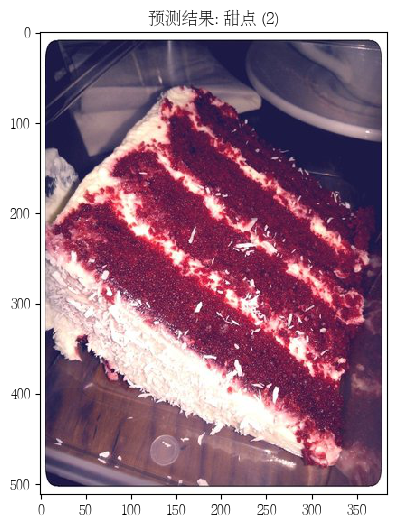

In [22]:
# 测试样例预测结果与可视化输出
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

# 设置中文字体（这里以 SimHei 为例，需确保系统安装了该字体）
rcParams['font.sans-serif'] = ['FZSongYi-Z13S']  # 设置中文字体
rcParams['axes.unicode_minus'] = False   # 解决负号显示问题

# 随机取样本展示,测试数据集样本量：3347
# 样本映射
LABEL_MAP = [
        "面包",
        "乳制品",
        "甜点",
        "鸡蛋",
        "油炸食品",
        "肉类",
        "面条or意大利面",
        "米饭",
        "海鲜",
        "汤",
        "蔬菜or水果",
    ]

idx = 1520
idx_str = 'work/food-11/testing/'+str(idx)+'.jpg'

predict_label = np.argmax(result[0][idx]) 
print('样本ID：{}, 预测标签：{}: {}'.format(idx,predict_label,LABEL_MAP[predict_label]))

image = Image.open(idx_str)
plt.figure(figsize=(10,6))
plt.imshow(image)
# plt.title('predict: {} {}'.format(predict_label, LABEL_MAP[predict_label]))
plt.title(f'预测结果: {LABEL_MAP[predict_label]} ({predict_label})')  # 中文标题
plt.show()